# Pairs Trading, a Machine Learning approach 

Pairs Trading is an arbitrage strategy involving two equities which prices have comoved in the past and is expected to do so in the future. The rationale behind is simple: at the entry point, short the stock which outperforms and long the underperforming stock. Afterward, liquidate the position at the exit point.

Here we use two Machine Learning algorithms namely, Recurrent Neural Networks (RNN) and Reinforcement Learning (RL) to support a Pairs Trading strategy on High-Frequency Data (HFD) from a set of 2365 stocks from 3 different US exchanges. 

## 1. Data pre-processing

### 1.1 Check on memory available

Since the raw data file is very large, we start by checking the amount of RAM available.

In [ ]:
# Finding the amount of RAM available
import psutil

svmem = psutil.virtual_memory()
print (svmem.available)

12785934336


### 1.2 Read the data

Decided to divide the raw data file in chucks while reading it, we define the size of each chunk and filter the raw data by trading days. In the end, we have 21 data frames, one for each trading day (saved in pickle format).



In [ ]:
# Getting the size of csv file
import os 

os.path.getsize('./data/TAQ-Jan2018.csv')

# Processing csv files in chunks
import pandas as pd

df_sample = pd.read_csv('./data/TAQ-Jan2018.csv', nrows=10)

# Getting the size of sample dataframe
df_sample_size = df_sample.memory_usage(index=True).sum()
print(df_sample_size)


# Define a chunksize that would occupy a maximum of 1Gb
# we divide by 10 because we have selected 10 lines in our df_sample
my_chunk = (1000000000 / df_sample_size)/10
my_chunk = int(my_chunk//1) # we get the integer part
print (my_chunk)

# Create the iterator
iter_csv = pd.read_csv('./data/TAQ-Jan2018.csv',iterator=True,chunksize=my_chunk)

# Concatenate according to a filter into result dataframe
trading_days = ['02jan2018','03jan2018','04jan2018','05jan2018','08jan2018','09jan2018','10jan2018',
                '11jan2018','12jan2018','16jan2018','17jan2018','18jan2018','19jan2018','22jan2018',
                '23jan2018','24jan2018','25jan2018','26jan2018','29jan2018','30jan2018','31jan2018']


for tday in trading_days:
    iter_csv = pd.read_csv('./data/TAQ-Jan2018.csv',iterator=True,chunksize=my_chunk)
    df_result = pd.concat([chunk[chunk["date"]=='{}'.format(tday)]
    for chunk in iter_csv])
    SRC_DATA_FILENAME='./data/{}.pkl'.format(tday)
    df_result.to_pickle(SRC_DATA_FILENAME)

### 1.3 Check the data

Now, we load the data frame regarding the fifth trading day (08.01.2018) and display the first five observations.

In [ ]:
# Load data into dataframe
input_file = './data/08jan2018.pkl' 
df = pd.read_pickle(input_file)

# Set the display sizes
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Print the first 5 observations
df.head()

,date,time_m,ex,sym_root,sym_suffix,tr_scond,size,price,tickerID,exchcd
18820885,08jan2018,10:14:28,A,A,NaN,F I,48,69.79,1,1
18820886,08jan2018,14:34:33,A,A,NaN,F,100,70.22,1,1
18820887,08jan2018,14:34:27,A,A,NaN,F I,10,70.21,1,1
18820888,08jan2018,14:10:57,A,A,NaN,NaN,100,70.28,1,1
18820889,08jan2018,14:17:37,A,A,NaN,F,100,70.24,1,1


In [ ]:
df.to_excel("./data/df.xlsx", sheet_name='08jan2018')

From the previous data frame, we are interested in the **date** and **time** of each trade, the stock symbol (**sym_root**) and **price**.

### 1.4 Keep observations within trading session

We will deal only with the trades that occurred within the core trading session, i.e., from 09:30:00 to 16:00:00.

In [ ]:
import datetime as dt

trading_days = ['02jan2018','03jan2018','04jan2018','05jan2018','08jan2018','09jan2018','10jan2018',
                '11jan2018','12jan2018','16jan2018','17jan2018','18jan2018','19jan2018','22jan2018',
                '23jan2018','24jan2018','25jan2018','26jan2018','29jan2018','30jan2018','31jan2018']

for tday in trading_days:
    # Load data into dataframe
    input_file = './data/{}.pkl'.format(tday)
    ts1 = pd.read_pickle(input_file)

    # Merge columns
    ts1['time_m'] = ts1['date'] + ts1['time_m']
    
    # Convert trade time series
    ts1['time_m'] = pd.to_datetime(ts1.time_m,format="%d%b%Y%H:%M:%S") 
    
    # Read date info and create start and end times
    yr = pd.to_datetime(ts1.time_m).iloc[0].year
    mo = pd.to_datetime(ts1.time_m).iloc[0].month
    dy = pd.to_datetime(ts1.time_m).iloc[0].day
    t_start = dt.datetime(yr,mo,dy,9,30,0) # session opeming time 09:30:00
    t_end = dt.datetime(yr,mo,dy,16,00,0)  # session closing time 16:00:00
 
    # Create a boolean expression for the core trading session
    bool = (ts1['time_m'] >= t_start) & (ts1['time_m'] <= t_end)
    
    # Remove ticks out of the core trading session
    ts1 = ts1[bool]

    # save the result to a pickle file
    RES_DATA_FILENAME='./data/trd_{}.pkl'.format(tday)
    ts1.to_pickle(RES_DATA_FILENAME) 

### 1.5 Convert data frame from tick data to frequency bars

Most traditional models require regularly spaced data. So we convert our HFD to regular intervals, that means, _bars_ of 6 seconds.

In [ ]:
import numpy as np


def pop_with_prices(df,tspan):
    
    #symbols = df['sym_root'].unique() # extract stocks' symbols
    symbols = ['A']
    # trading day timespan
    yr = pd.to_datetime(df.date).iloc[0].year
    mo = pd.to_datetime(df.date).iloc[0].month
    dy = pd.to_datetime(df.date).iloc[0].day
    t_start = dt.datetime(yr,mo,dy,9,30,0) # session opeming time 09:30:00
    t_end = dt.datetime(yr,mo,dy,16,00,0)  # session closing time 16:00:00
    if tspan == 1:
        date_rng = pd.date_range(start=t_start, end=t_end, freq='T') #by minute
    elif tspan == 2:
        date_rng = pd.date_range(start=t_start, end=t_end, freq='30T') #by 1/2 hour
    elif tspan == 3:
        date_rng = pd.date_range(start=t_end, end=t_end, freq='D') #by day (close price)
    elif tspan == 4:
        date_rng = pd.date_range(start=t_start, end=t_end, freq='6S') #by 6 seconds
            
    # Create data frame w/ the same dimension as date_rng
    ds = pd.DataFrame(index=date_rng)
    
    for sym in symbols:
        ts1 = df.loc[df['sym_root']==sym] # select stock

        ts1 = ts1.sort_values(by=['time_m'])
            
        ds[sym] = np.nan

        for time in date_rng:
            for trade in ts1['time_m']:
                if time.hour==trade.hour and time.minute==trade.minute and time.second==trade.second:
                    sel = ts1.loc[ts1['time_m']==trade]
                    ds[sym].loc[time]=sel.price.median() # keep median
                                     
                
    return ds        

   
trading_days = ['02jan2018','03jan2018','04jan2018','05jan2018','08jan2018','09jan2018','10jan2018',
                '11jan2018','12jan2018','16jan2018','17jan2018','18jan2018','19jan2018','22jan2018',
                '23jan2018','24jan2018','25jan2018','26jan2018','29jan2018','30jan2018','31jan2018']

for tday in trading_days:
  # Load data into dataframe
  input_file = './data/trd_{}.pkl'.format(tday)
  ts1 = pd.read_pickle(input_file)
  
  # Call pop_with_prices function  
  df = pop_with_prices(ts1,4) 

  # save the result to a pickle file
  RES_DATA_FILENAME='./data/trd_median6s_{}.pkl'.format(tday)
  ts1.to_pickle(RES_DATA_FILENAME) 


### 1.6 Selection of stocks regarding liquidity

Some stocks trade more frequently (more liquid) than others. We can verify that by plotting a Null Matrix of the first 5 stocks in our DataFrame where light shades represent the absence of observations (or null values).

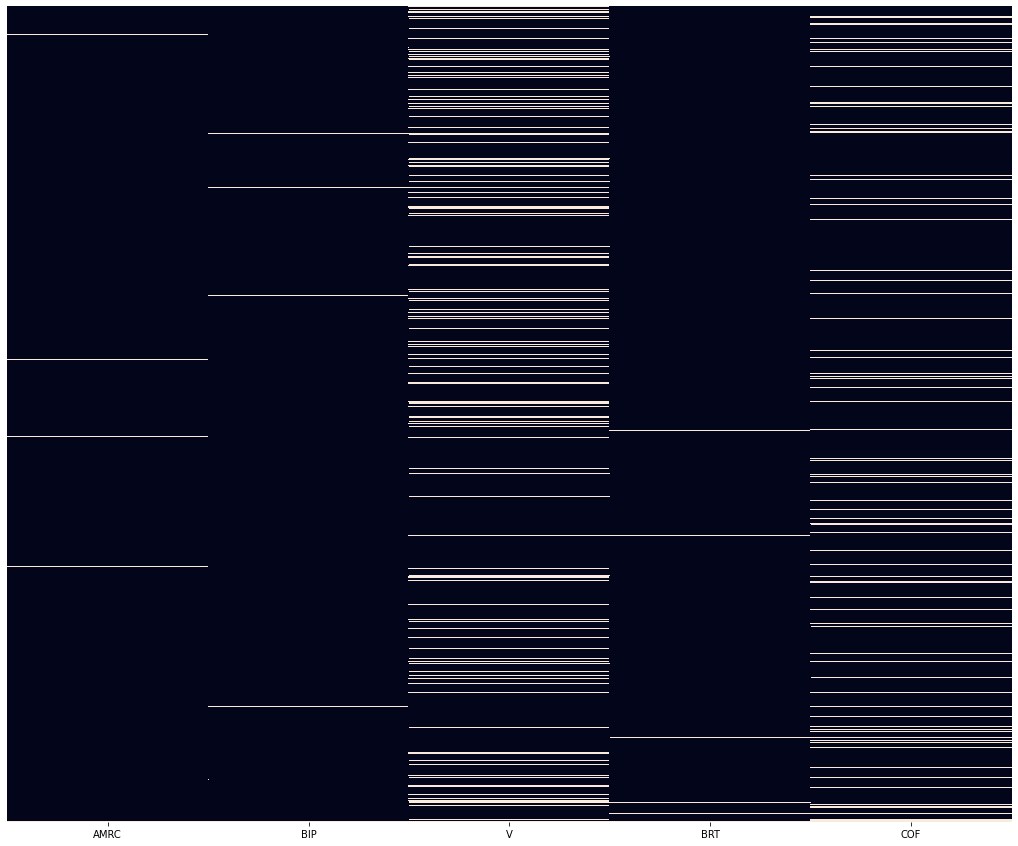

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to plot the Null matrix
def plot_null_matrix(df, figsize=(18,15)):
    # initiate the figure
    plt.figure(figsize=figsize)
    # create a boolean dataframe based on whether values are NaN
    df_null = df.isnull()
    # create a jeatmap of the boolean dataframe
    sns.heatmap(~df_null, cbar=False, yticklabels=False)
    plt.show()

# Load data into dataframe
input_file = './data/trd_median6s_08jan2018.pkl'
df = pd.read_pickle(input_file)

# Call the function
plot_null_matrix(df.iloc[:,:5])

For this analysis, we will keep the more liquid stocks based on a threshold: at least 45% of the maximum number of trades per day.

In [ ]:
# Extract index from dataframe
symbols = df.columns

# Create data frame using columns names as index
ds = pd.DataFrame(index=symbols)
ds['count'] = np.nan


# Build tick frequency series
for sym in df:
    freq = df[sym].value_counts().sum()    
    ds.loc[sym] = freq

# Create a conditional vector for stocks with ticks 45% (or above) maximum 
bool = ds['count'] >= ds['count'].max()*0.45

# Selection of most liquid stocks
liq = ds[bool]

# Build a data frame with selected stocks
sample = df[liq.index]

### 1.7 Filling the bar gaps

From the result above, we now fill the missing observations with the _last_ bar value.

In [ ]:
import math

# Define a function to fill the missing observations with the last bar value
def filling_bars(ds):
    symbols = ds.keys() # extract stocks' symbols                      
    #fill missing values with last bar
    for sym in symbols:   
        for k in range(len(ds)):          
            if math.isnan(ds[sym].iloc[k]) and k==0:
                j = ds[sym].index.get_loc(ds[sym].first_valid_index())
                ds[sym].iloc[k] = ds[sym].iloc[j]           
    
            elif  math.isnan(ds[sym].iloc[k]):
                ds[sym].iloc[k] = ds[sym].iloc[k-1]          
    return ds

# Call the function
filling_bars(sample)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,V,DAL,IBM,VIPS,SQ,LB,D,WU,HD,JPM,CAT,BAC,CVX,CVS,XOM,STZ,GS,M,GE,UTX,SNAP,WFC,WMT,TWTR,NKE,BABA,TGT,BA,X,HAL,KSS,SM,T,C,DIS,SLB
2018-01-08 09:30:00,118.5400,55.930,162.790,12.745,41.0600,50.08,77.140,21.7750,191.72,26.600,164.050,30.220,127.88,78.3600,86.700,219.750,26.945,24.660,18.670,135.380,14.190,62.67,100.30,24.350,64.2325,190.38,67.470,308.600,38.85,51.70,58.62,24.000,38.155,75.15,111.040,73.3200
2018-01-08 09:30:06,118.5300,55.930,162.790,12.745,41.0600,50.08,77.100,21.7750,191.72,26.865,164.050,30.220,127.88,78.4300,86.700,222.720,254.530,24.660,18.640,135.380,14.190,62.67,100.30,24.350,64.2325,190.38,67.470,308.600,38.85,51.70,58.62,24.000,38.155,75.15,111.040,73.3200
2018-01-08 09:30:12,118.6600,55.930,162.790,12.780,41.0600,50.08,77.100,21.7750,191.72,26.865,164.050,30.230,127.88,78.4300,86.700,222.720,254.530,24.720,18.670,135.380,14.200,62.67,100.30,24.350,64.2325,190.38,67.470,308.120,38.85,51.70,58.46,24.000,38.155,75.15,111.040,73.3200
2018-01-08 09:30:18,118.5700,55.930,162.790,12.740,41.0600,50.08,77.095,21.7750,191.72,26.865,164.050,30.220,127.88,78.4300,86.700,219.745,254.530,24.720,18.680,135.380,14.200,62.67,100.24,24.350,64.2325,190.38,67.470,308.120,38.85,51.70,58.46,24.000,38.155,75.15,111.040,73.3200
2018-01-08 09:30:24,118.5700,55.930,162.790,12.800,41.0600,50.08,77.020,21.7750,191.72,26.865,164.050,30.210,127.88,78.4300,86.700,219.745,254.530,24.720,18.680,135.475,14.200,62.67,100.24,24.350,64.2325,190.38,67.470,308.120,38.85,51.70,58.46,24.000,38.155,75.15,111.040,73.3200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-08 15:59:36,119.3700,54.645,163.500,13.590,40.7000,48.66,78.030,21.4875,192.06,108.530,166.160,30.110,128.57,77.8000,87.125,216.900,251.830,24.410,18.275,132.840,14.055,61.99,101.61,24.600,64.5700,190.28,67.175,310.230,39.45,52.32,56.88,25.125,38.250,74.55,110.020,74.8725
2018-01-08 15:59:42,119.3700,54.645,163.500,13.585,40.6900,48.66,78.020,21.4950,192.07,108.540,166.105,30.115,128.57,77.7800,87.130,216.980,251.750,24.425,18.275,132.805,14.060,62.03,101.59,24.590,64.5800,190.21,67.155,310.235,39.46,52.32,56.90,25.125,38.240,74.55,110.020,74.8200
2018-01-08 15:59:48,119.4175,54.680,163.470,13.590,40.6905,48.66,78.030,21.4950,192.14,108.550,166.140,30.115,128.62,77.7925,87.120,216.880,251.800,24.430,18.280,132.840,14.050,62.02,101.62,24.610,64.5900,190.30,67.175,310.310,39.42,52.31,56.92,25.125,38.230,74.56,110.030,74.8300
2018-01-08 15:59:54,119.4050,54.675,163.445,13.580,40.7500,48.65,78.050,21.5000,192.14,108.550,166.095,30.115,128.62,77.7925,87.120,216.880,251.800,24.450,18.280,132.830,14.050,62.03,101.64,24.610,64.5800,190.34,67.175,310.120,39.42,52.31,56.92,25.110,38.230,74.53,110.025,74.8300


### 1.8 Remove the outliers

We will delete entries for which price deviates by more than 10 mean absolute deviations from a rolling centered median of 50 observations (25 observations before and 25 after). When computing the rolling centered median we do not include the observation under consideration.

In [ ]:
from datetime import timedelta

# Define a function to remove outliers
def out_remov(df):
    # Build a list with stocks symbols
    syms = df.columns
    
    time_period = 51 # number of observations over which to compute statistics
       
    for sym in syms:
  
        history = [] # create an empty list to track a history of prices
        history2 = [] # create s second empty list to track a history of prices 
        smm = np.nan # create an empty var to track simple moving median values (w/o the 26th observation)
        mad = np.nan # create an empty var to track mean absolute deviation (w/o the 26th observation)
        tick = np.nan # create an empty var to track the 26th observation on every time period
 
        for i in sample.index:
            history.append(df[sym][i])
            
            if len(history) == time_period: 
                
                history2 = history[0:len(history)] 
                tick = history2[25]
                history2.pop(25)
                history2=pd.Series(history2)       
                smm = history2.median()
                '''remove ouliers inside the time period before computing MAD'''                       
                mad = history2.mad(skipna=True)
                if (tick > smm+(mad*10)) or (tick < smm-(mad*10)):
                    df[sym].loc[i-timedelta(seconds=150)]=np.nan
                    
                
            elif len(history) > time_period:
                # remove oldest price because we only average over last 'time_period' prices
                del (history[0])     
                history2 = history[0:len(history)] 
                tick = history2[25]
                history2.pop(25)
                history2=pd.Series(history2)        
                smm = history2.median()
                '''remove ouliers inside the time period before computing MAD'''
                        
                mad = history2.mad(skipna=True) 

                if (tick > smm+(mad*10)) or (tick < smm-(mad*10)):
                    df[sym].loc[i-timedelta(seconds=150)]=np.nan
                    
    return df




In [ ]:
# Call function
sample = out_remov(sample)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Check the result
nulls = sample.isnull().sum()
nans = nulls.index[np.where(nulls!=0)]

sample[nans].describe()

,DAL,VIPS,HD,JPM,BAC,CVX,GS,M,GE,WFC,HAL,C
count,3900.000000,3899.000000,3900.000000,3881.000000,3870.000000,3898.000000,3890.000000,3900.000000,3894.000000,3882.000000,3898.000000,3873.000000
mean,54.748747,13.380432,192.542617,106.096100,60.056999,128.087979,225.512801,24.274618,18.235630,96.293008,51.818211,71.429561
std,0.215013,0.229471,0.415315,12.905324,189.305342,0.162417,74.298115,0.260283,0.107873,221.337790,0.247351,11.822080
min,54.510000,12.740000,191.680000,25.300000,2.280000,127.660000,22.230000,23.700000,18.110000,25.010000,51.400000,25.430000
25%,54.630000,13.140000,192.220000,108.290000,30.105000,127.960000,252.660000,24.100000,18.175000,62.020000,51.630000,74.515000
50%,54.700000,13.500000,192.440000,108.360000,30.125000,128.080000,252.960000,24.360000,18.200000,62.150000,51.720000,74.580000
75%,54.775000,13.580000,192.750000,108.435000,30.145000,128.180000,253.270000,24.440000,18.275000,62.290000,51.980000,74.630000
max,55.980000,13.675000,193.710000,108.680000,1314.400000,128.620000,255.175000,25.070000,18.700000,1281.600000,52.350000,75.200000


The result above shows the descriptive statistics of stocks with outliers. We can notice that some of them still have problems (like WFC with the maximum value of 1281.60 where the mean is 96.29). This is due to the great variance inside the sample period to compute the MAD. Trying to change the size of the sampling period doesn't help much. So, we simply drop these stocks.

In [ ]:
# Select stocks with issues
rid = ['JPM','BAC','GS','WFC','C']

# Keep stocks without issues regarding outliers removal
sample = sample.drop(columns=rid)

Finally, we can replace the missing observations (previously treated as outliers) with the _last_ bar value.

In [ ]:
# count number of NAN's
nulls = sample.isnull().sum() 

# check which stock has NAN's
nans = nulls.index[np.where(nulls!=0)]
print(nans)

# Fill missing values with last bar value
filling_bars(sample)

Index(['DAL', 'VIPS', 'HD', 'CVX', 'M', 'GE', 'HAL'], dtype='object')


,V,DAL,IBM,VIPS,SQ,LB,D,WU,HD,CAT,CVX,CVS,XOM,STZ,M,GE,UTX,SNAP,WMT,TWTR,NKE,BABA,TGT,BA,X,HAL,KSS,SM,T,DIS,SLB
2018-01-08 09:30:00,118.5400,55.930,162.790,12.745,41.0600,50.08,77.140,21.7750,191.72,164.050,127.88,78.3600,86.700,219.750,24.660,18.670,135.380,14.190,100.30,24.350,64.2325,190.38,67.470,308.600,38.85,51.70,58.62,24.000,38.155,111.040,73.3200
2018-01-08 09:30:06,118.5300,55.930,162.790,12.745,41.0600,50.08,77.100,21.7750,191.72,164.050,127.88,78.4300,86.700,222.720,24.660,18.640,135.380,14.190,100.30,24.350,64.2325,190.38,67.470,308.600,38.85,51.70,58.62,24.000,38.155,111.040,73.3200
2018-01-08 09:30:12,118.6600,55.930,162.790,12.780,41.0600,50.08,77.100,21.7750,191.72,164.050,127.88,78.4300,86.700,222.720,24.720,18.670,135.380,14.200,100.30,24.350,64.2325,190.38,67.470,308.120,38.85,51.70,58.46,24.000,38.155,111.040,73.3200
2018-01-08 09:30:18,118.5700,55.930,162.790,12.740,41.0600,50.08,77.095,21.7750,191.72,164.050,127.88,78.4300,86.700,219.745,24.720,18.680,135.380,14.200,100.24,24.350,64.2325,190.38,67.470,308.120,38.85,51.70,58.46,24.000,38.155,111.040,73.3200
2018-01-08 09:30:24,118.5700,55.930,162.790,12.800,41.0600,50.08,77.020,21.7750,191.72,164.050,127.88,78.4300,86.700,219.745,24.720,18.680,135.475,14.200,100.24,24.350,64.2325,190.38,67.470,308.120,38.85,51.70,58.46,24.000,38.155,111.040,73.3200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-08 15:59:36,119.3700,54.645,163.500,13.590,40.7000,48.66,78.030,21.4875,192.06,166.160,128.57,77.8000,87.125,216.900,24.410,18.275,132.840,14.055,101.61,24.600,64.5700,190.28,67.175,310.230,39.45,52.32,56.88,25.125,38.250,110.020,74.8725
2018-01-08 15:59:42,119.3700,54.645,163.500,13.585,40.6900,48.66,78.020,21.4950,192.07,166.105,128.57,77.7800,87.130,216.980,24.425,18.275,132.805,14.060,101.59,24.590,64.5800,190.21,67.155,310.235,39.46,52.32,56.90,25.125,38.240,110.020,74.8200
2018-01-08 15:59:48,119.4175,54.680,163.470,13.590,40.6905,48.66,78.030,21.4950,192.14,166.140,128.62,77.7925,87.120,216.880,24.430,18.280,132.840,14.050,101.62,24.610,64.5900,190.30,67.175,310.310,39.42,52.31,56.92,25.125,38.230,110.030,74.8300
2018-01-08 15:59:54,119.4050,54.675,163.445,13.580,40.7500,48.65,78.050,21.5000,192.14,166.095,128.62,77.7925,87.120,216.880,24.450,18.280,132.830,14.050,101.64,24.610,64.5800,190.34,67.175,310.120,39.42,52.31,56.92,25.110,38.230,110.025,74.8300


Let's save the result as a pickle file for later use.

In [ ]:
  # save the result to a pickle file
  RES_DATA_FILENAME='./data/bars_6s_08jan2018.pkl'
  sample.to_pickle(RES_DATA_FILENAME) 

## 2. Finding trading pairs

### 2.1 Cointegration test

We are now interested in screening pairs of stocks to use in the trading phase. There are two methods: (1) the Metric approach, and (2) the Cointegration approach.

Here we will use the Cointegration approach. The idea is to apply the augmented Engle-Granger two-step cointegration test on the stocks into consideration to screen the most promising co-movers. The Null hypothesis is that there is no cointegration.

In [1]:
from statsmodels.tsa.stattools import coint

# Define a function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.02: # only p-values lower than 0.02
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Before calling the function to find cointegrated pairs, we concatenate bars of 2 trading days. The stocks that are not present on both trading days will be dropped.

In [10]:
import numpy as np

# Load data into dataframe
input_file = './data/bars_6s_04jan2018.pkl'
df1 = pd.read_pickle(input_file)

input_file2 = './data/bars_6s_05jan2018.pkl'
df2 = pd.read_pickle(input_file2)

# Concatenate dataframes
df = pd.concat([df1,df2],ignore_index=False)

# Count number of NAN's
nulls = df.isnull().sum()

# Check which stock has NAN's
nans = nulls.index[np.where(nulls!=0)]

# Keep stocks without NAN's
df = df.drop(columns=nans)

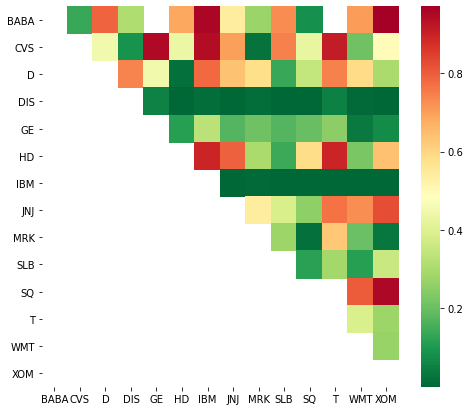

In [12]:
# Call the function
pvalues, pairs = find_cointegrated_pairs(df)

# extract stocks' symbols
symbolsIds = list(df.columns)

# Create a heatmap to visualize pairs p-values
sns.heatmap(pvalues, xticklabels=symbolsIds,yticklabels=symbolsIds, cmap='RdYlGn_r',mask = (pvalues >= 0.98))
# plt.title('Cointegration HeatGraph',pad=10)
plt.rcParams["figure.figsize"] = (8,7)
plt.show()

The Heat Graph above classifies pairs according to the Cointegration test p-value. We are interested in p-values lower than 0.02, which means, the greener the better.

We can also check how many pairs there are and the number of unique tickers.

In [ ]:
print("There are {0} pairs with {1} unique tickers. Let's check the plot of one of those pairs.".format(len(pairs), 
len(np.unique(pairs))))

There are 17 pairs with 28 unique tickers. Let's check the plot of one of those pairs.


In [13]:
pairs

[('D', 'HD'),
 ('DIS', 'HD'),
 ('DIS', 'IBM'),
 ('DIS', 'JNJ'),
 ('DIS', 'MRK'),
 ('DIS', 'SLB'),
 ('DIS', 'SQ'),
 ('DIS', 'WMT'),
 ('DIS', 'XOM'),
 ('IBM', 'JNJ'),
 ('IBM', 'MRK'),
 ('IBM', 'SLB'),
 ('IBM', 'SQ'),
 ('IBM', 'T'),
 ('IBM', 'WMT'),
 ('IBM', 'XOM'),
 ('MRK', 'SQ')]

DIS and SQ stocks seem to be good candidates for a pair. Let's check them out.

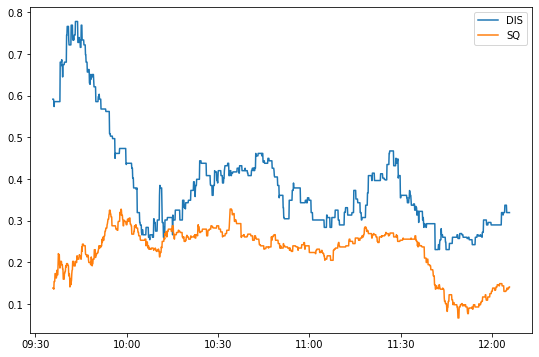

In [16]:
from matplotlib.dates import DateFormatter

pair = ['DIS', 'SQ']
data=(df[pair]-df[pair].min())/(df[pair].max()-df[pair].min())

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(data[58:1558])
ax.legend(pair,loc=0)
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
# plt.ylabel('Normalized prices')

At there very beginning of the first trading day, the two stocks look like to be positively correlated. The situation then changes for a negative correlation, but overall they seem to comove during the first 2.5 trading hours.

### 2.2 Synthetic Asset

Synthetic is the term given to financial instruments designed to mimic other instruments with key features. Here we will use the spread between pair's stocks. Instead of using the plain difference between stock prices, we will use a linear regression model to accommodate the distinction in magnitude between prices. We will also use rolling statistics to avoid _Look Ahead_ bias.

In [ ]:
S1 = df[pair[0]]
S2 = df[pair[1]]

score, pvalue, _ = coint(S1, S2)
pvalue

0.0033154423636365866

As we can see above, the p-value is low enough and indicate that those stocks may be cointegrated.

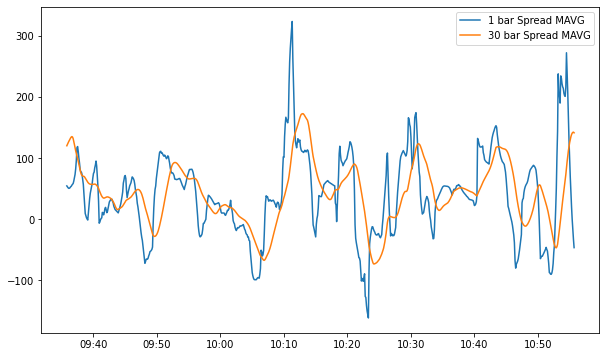

In [ ]:
# Get the spread between the 2 stocks
from pyfinance import ols

# Calculate rolling beta coefficient
rolling = ols.PandasRollingOLS(y=S1, x=S2, window=30)
spread = S2 - rolling.beta['feature1'] * S1
spread.name = 'spread'

# Get the 1 day moving average of the price spread
spread_mavg1 = spread.rolling(1).mean()
spread_mavg1.name = 'spread 1b mavg'

# Get the 30 day moving average
spread_mavg30 = spread.rolling(30).mean()
spread_mavg30.name = 'spread 30b mavg'

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(spread_mavg1[58:858].index, spread_mavg1[58:858].values)
ax.plot(spread_mavg30[58:858].index, spread_mavg30[58:858].values)
ax.legend(['1 bar Spread MAVG', '30 bar Spread MAVG'])
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))

Now we will compute the Z-Score for the spread. The Z-Score shows how far a piece of data is from the population mean. This will help us to choose the direction of trading. If the Z-Score value is positive, this means that the spread is higher than the average value. In a mean reversion process (our case), the spread is expected to go down after going up.

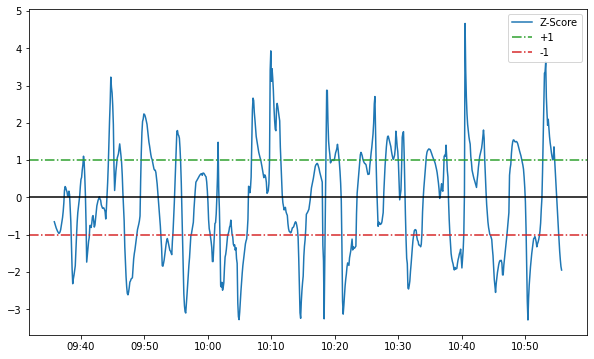

In [ ]:
# Take a rolling 30 day standard deviation
std_30 = spread.rolling(30).std()
std_30.name = 'std 30b'

# Compute the z score for each bar
zscore_30_1 = (spread_mavg1 - spread_mavg30)/std_30
zscore_30_1.name = 'z-score'

# Plot the results
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(zscore_30_1[58:858].index,zscore_30_1[58:858].values,label='Z-Score')
ax.axhline(0, color='black')
ax.axhline(1, color='tab:green', linestyle='-.',label='+1',lw=1.5);
ax.axhline(-1, color='tab:red', linestyle='-.',label='-1',lw=1.5);
ax.legend(loc=0)
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))

The graph above shows a stationary behavior of the Z-Score during the first 2.5 hours of the first trading day which is an indication of a mean-reverting process.

## 3. Forecasting

Forecasting is a tool that uses historical data as input to predict the course of future patterns in an informed way.

Here, we are interested in predict 15 timesteps ahead, that means, fifteen 6-sec bars, or the movement of the spread in the next 1.5 minutes.

For this regard, we will use a Recurrent Neural Network (RNN), but first, we need to deal with the missing bars (due to the previous rolling statistics computations) and also scale the data appropriately.

In [ ]:
from sklearn import preprocessing

# Remove NaN values
zscore_30_1 = zscore_30_1[~np.isnan(zscore_30_1)]

# Scaling features to a range [0, 1]
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
zscore_30_1_norm = min_max_scaler.fit_transform(np.expand_dims(zscore_30_1, axis=1))

# Create a function to get time series data into RNN format
def create_univariate_rnn_data(data,window_size):
    data = data.reshape(-1,1) # transform data into 2D
    n = data.shape[0]
    ts = np.hstack(tuple([data[i:n-j,:] for i,j in enumerate(range(window_size,0,-1))]))
    ts = ts[...,np.newaxis].astype(np.float32)
    return ts

Now we split the data into 3 subsets: _Train_, _Validation_, and _Test_. We also define a function to compute the Mean Square Error (MSE) at each time step.

In [ ]:
# Create an RNN that predicts the next 15 steps at each time step

n_steps = 50
ts = create_univariate_rnn_data(zscore_30_1_norm, n_steps +15)

# Split dataset
n_train = int(ts.shape[0] * 0.7)
n_valid = int(ts.shape[0] * 0.9)
n_test = int(ts.shape[0] * 1.0)

# Split series into 'train' ,'valid' and 'test' sub-series
X_train = ts[:n_train, :n_steps]
X_valid = ts[n_train:n_valid, :n_steps]
X_test = ts[n_valid:, :n_steps]

Y = np.empty((n_test, n_steps, 15))
for step_ahead in range(1, 15 + 1):
    Y[..., step_ahead - 1] = ts[..., step_ahead:step_ahead + n_steps, 0]

Y_train = Y[:n_train]
Y_valid = Y[n_train:n_valid]
Y_test = Y[n_valid:]

# Create a function to compute the MSE at each time step
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

Finally, we define an RNN using 4 LSTM layers (50 neurons each) and run the model.

In [ ]:
from tensorflow import keras

# Create a model using LSTM
model = keras.models.Sequential([
    keras.layers.LSTM(50, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(15))
])

# Call the model
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
168/168 [==============================] - 18s 106ms/step - loss: 0.0610 - last_time_step_mse: 0.0595 - val_loss: 0.0643 - val_last_time_step_mse: 0.0638
Epoch 2/20
168/168 [==============================] - 16s 97ms/step - loss: 0.0497 - last_time_step_mse: 0.0488 - val_loss: 0.0596 - val_last_time_step_mse: 0.0589
Epoch 3/20
168/168 [==============================] - 16s 98ms/step - loss: 0.0465 - last_time_step_mse: 0.0456 - val_loss: 0.0571 - val_last_time_step_mse: 0.0559
Epoch 4/20
168/168 [==============================] - 17s 100ms/step - loss: 0.0448 - last_time_step_mse: 0.0433 - val_loss: 0.0565 - val_last_time_step_mse: 0.0556
Epoch 5/20
168/168 [==============================] - 17s 100ms/step - loss: 0.0438 - last_time_step_mse: 0.0416 - val_loss: 0.0589 - val_last_time_step_mse: 0.0587
Epoch 6/20
168/168 [==============================] - 17s 102ms/step - loss: 0.0420 - last_time_step_mse: 0.0386 - val_loss: 0.0588 - val_last_time_step_mse: 0.0584
Epoch 7/20
1

In [ ]:
model.evaluate(X_valid, Y_valid)

48/48 [==============================] - 1s 23ms/step - loss: 0.0763 - last_time_step_mse: 0.0853


[0.07625771313905716, 0.08534184098243713]

The validation loss varies from 0.0571 to 0.0766 depending on the episode. Overall loss is 0.0763.

Now let's plot some forecasted points.

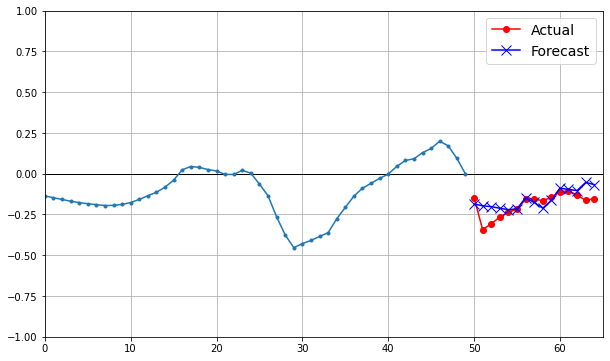

In [ ]:
import matplotlib as mpl

def plot_series(series, y=None, y_pred=None, x_label="", y_label=""):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=90)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])



def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

# Predict using model    
X_New, Y_New = ts[:, :50, :], ts[:, 50:, :]
Y_Pred = model.predict(X_New)[:, -1][..., np.newaxis]
    
plot_multiple_forecasts(X_New, Y_New, Y_Pred)
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

As we can check see graphically model is quite accurate when predicting the next 15 data points. Let's plot more points.

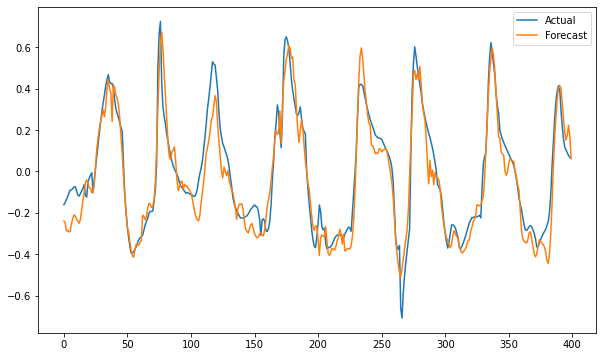

In [ ]:
X_new = Y_New[0,:,:]

for i in range(1,len(Y_New)):
    X_new = np.vstack((X_new,Y_New[i,-1,:]))
    
X_pred = Y_Pred[0,:,:]

for i in range(1,len(Y_Pred)):
    X_pred = np.vstack((X_pred,Y_Pred[i,-1,:]))
    
    
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(X_new[1158:1558])
ax.plot(X_pred[1158:1558])
ax.legend(['Actual','Forecast'],loc=0)
# plt.xlabel('Bars')
# plt.ylabel('Z-Score')
plt.show()

In [ ]:
np.mean(X_pred), np.min(X_pred),np.max(X_pred)

(-0.05677247, -0.89882576, 0.67457175)

## 4. Trade phase

This is the second part of Pairs Trading. Primarily we define a trading strategy based on the Z-Score of the spread previously computed. We will enter in a short position for the first stock of the pair (and long the second one) when the spread deviates +2 standards deviations from the mean and liquidate the position when the spread is +0.5 standard deviation from the mean. In the same sense, we enter a long position for the first stock of the pair (and short the second one) when the spread is -2 standards deviations from the mean, and exit the position when the spread reaches -0.5 standard deviations from the mean. The stop-loss limits for the short and long positions are respectively +3.0 and -3.0 standard deviations from the mean.

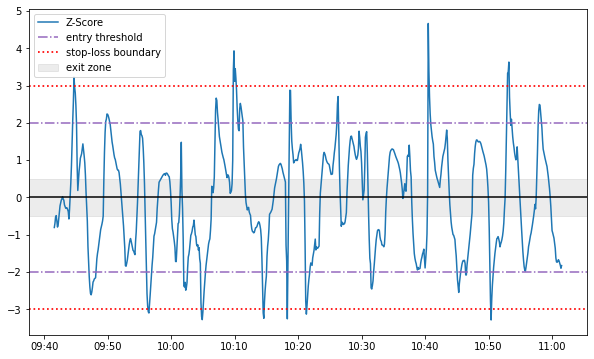

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(zscore_30_1[58:858].index,zscore_30_1[58:858].values,label='Z-Score')
ax.axhspan(-0.5, 0.5, alpha=0.15, color='grey', label='exit zone')
ax.axhline(0, color='black')
ax.axhline(2, color='tab:purple', linestyle='-.',label='entry threshold',lw=1.5);
ax.axhline(-2, color='tab:purple', linestyle='-.',lw=1.5);
ax.axhline(-3, color='red', linestyle=':',lw=1.7);
ax.axhline(3, color='red', linestyle=':',label='stop-loss boundary',lw=1.7);
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax.legend(loc=0)

### 4.1 Reinforcement Learning

Reinforcement Learning (RL) is today one of the most exciting areas of Machine Learning. In RL there is a software agent that makes observations, performs actions, and receives awards in return. Its goal is to learn how to act so that its expected rewards can be maximized over time.

In order to use RL, we need to prepare our dataset accordingly. First, we take care of NANs entries and generate a response variable y using the trading strategy mentioned before: enter in a short position for the first stock of the pair (and long the second one) when the spread deviates +2 standards deviations from the mean, liquidate the position when the spread is +0.5 standard deviation from the mean, and so on. Response variable assumes value 1 for a long position, -1 for a short position, and 0 for a hold position.

In [27]:
def prepare_dataset(zscore_30_1):
    """
    Function prepare_dataset to generate input data and trading strategy from stock prices
    """
 
    zscore_30_1 = zscore_30_1[~np.isnan(zscore_30_1)]

    # Scaling features to a range [0, 1]
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    zscore_30_1_norm = min_max_scaler.fit_transform(np.expand_dims(zscore_30_1, axis=1))


    # Implement strategy
    start_short = 0.5
    stop_short = 0.1
    start_long = -0.5
    stop_long = -0.1
    lower_bound = -0.75
    upper_bound = 0.75

    y = np.full(len(zscore_30_1_norm), np.nan)
    y[0] = 0

    for i in range(1, len(zscore_30_1_norm)):

        if y[i-1] == 0:
            if (zscore_30_1_norm[i] >= start_short) and (zscore_30_1_norm[i] < upper_bound):
                # Enter short position
                y[i] = -1
            elif (zscore_30_1_norm[i] <= start_long) and (zscore_30_1_norm[i] > lower_bound):
                # Enter long position
                y[i] = 1
            else:
                y[i] = 0
        elif y[i-1] == -1:
            if (zscore_30_1_norm[i] > stop_short) and (zscore_30_1_norm[i] < upper_bound):
                # Stay in short position
                y[i] = -1
            else:
                y[i] = 0
        elif y[i-1] == 1:
            if (zscore_30_1_norm[i] < stop_long) and (zscore_30_1_norm[i] > lower_bound):
                # Stay in long position
                y[i] = 1
            else:
                y[i] = 0

    # Plot strategy

    fig, ax = plt.subplots()
    dates = np.arange(len(zscore_30_1_norm))
    ax.axhspan(-0.1, 0.1, alpha=0.1, color='purple', label='exit zone')
    plt.rcParams["figure.figsize"] = (10,6)
    ax.plot(dates, y,'g', label='Strategy Positions')
    ax.plot(dates, zscore_30_1_norm, color='tab:blue', label='Z-Score')
    ax.plot(dates, upper_bound * np.ones(len(zscore_30_1_norm)), color='red', linestyle=':', lw=1.5,label='stop-loss boundary')
    ax.plot(dates, lower_bound * np.ones(len(zscore_30_1_norm)), color='red', linestyle=':', lw=1.5)
    ax.plot(dates, start_short * np.ones(len(zscore_30_1_norm)), color='tab:purple', linestyle='-.', lw=1.5,label='entry threshold')
    ax.plot(dates, start_long * np.ones(len(zscore_30_1_norm)), color='tab:purple', linestyle='-.', lw=1.5)
    plt.xlabel('Bars')
    plt.xlim((300, 600))
    ax.set_yticklabels(['','long',-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,'short'])
    plt.legend(loc='best',bbox_to_anchor=(0, 0.51, 0.74, 0.5))
    plt.savefig('./images/spread.png', bbox_inches='tight')
    plt.show()
    

    x = zscore_30_1_norm


    return x, y

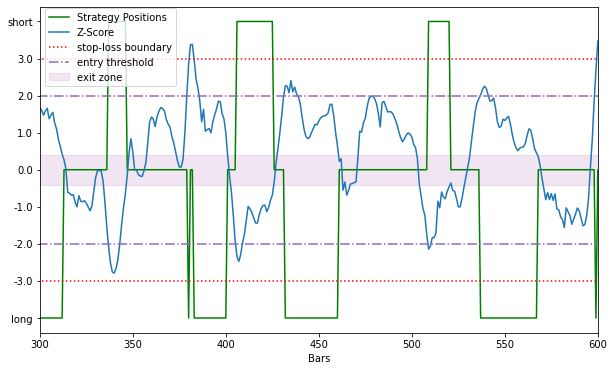

In [ ]:
#Implement trading strategy
X, y = prepare_dataset(X_pred)

In [ ]:
print("There are {0} \"long\" signals and {1} \"short\" signals within the period. The rest of time is to stay put.".format(np.count_nonzero(y == 1), np.count_nonzero(y == -1)))

There are 489 "long" signals and 1666 "short" signals within the period. The rest of time is to stay put.


From the previous graph, we can check that using our strategy, we enter a short position 3 times and a long position 6 times during the depicted timeframe.

Now we split the dataset into train subset (80%), test subset (20%), and also center the data.

In [ ]:
# Split dataset
n_train = int(X.shape[0] * 0.8)

X_train, y_train = X[:n_train], y[:n_train]
X_test, y_test = X[n_train:], y[n_train:]

# Normalize data
scaler = preprocessing.MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Encode trading signal with integers between 0 and n-1 classes
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

print(le.classes_)

[-1.  0.  1.]


### 4.2 Create and train the Agent

The agent is a learning component that decides what to do to maximize the reward. The following are the steps of RL:

1.   The agent observes the environment's state.
2.   The agent takes a policy-based action.
3.   The agent receives the corresponding reward and the next environmental state.
4.   Information on the reward is recorded for the given state/action and used to update the policy.

Deep Q-learning is a widely used method among the available RL algorithms. The purpose is to learn a policy to model the selection of the agent through trial and error.

While a purely random policy ensures that all state/action dual will ultimately be visited several times, this will take an incredibly long time. We will use the ε-greedy policy here: at each step, the agent acts randomly with probability ε, or greedily with probability 1–ε, that means, it chooses the action with the highest one.

Let's create a class for the agent.

In [ ]:
import random

from collections import deque

from keras.models import Sequential
from keras.layers import Dense, Flatten


# Deep Q-learning Agent
class Agent:

    def __init__(self, look_back, action_size, n_features):

        self.look_back = look_back          # fixed window of historical prices
        self.action_size = action_size      # buy, sell, hold
        self.n_features = n_features
        
        self.memory = deque(maxlen=3000)    # list of experiences

        self.gamma = 0.95                   # discount rate
        self.epsilon = 1.0                  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        
        self.model = self.create_DQN()


    def create_DQN(self):
        """
        Function create_DQN to implement the deep Q-network as a MLP
        """

        # input: stock price
        # output: decision

        model = Sequential()
        model.add(Dense(30, input_shape=(self.look_back, self.n_features), activation='relu'))
        model.add(Dense(15, activation='relu'))
        model.add(Dense(5, activation='relu'))
        model.add(Flatten())
        model.add(Dense(self.action_size, activation='linear'))

        model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

        return model


    def remember(self, state, action, reward, next_state, done):
        """
        Function remember to store states, actions ad rewards by appending elements to the memory list
        """
        self.memory.append((state, action, reward, next_state, done))


    def replay(self, batch_size):
        """
        Function replay to train the deep Q-network according to the experience replay strategy
        """
        
        # Random minibatch of experiences
        mini_batch = random.sample(self.memory, batch_size)

        # Information from each experience
        for state, action, reward, next_state, done in mini_batch:

            if done:
                # End of episode, make our target reward
                target = reward

            else:
                # estimate the future discounted reward
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

            # Calculate the target associated to the current state
            target_f = self.model.predict(state)
            # Update the Q-value for the action according to Belmann equation
            target_f[0][action] = target

            # Train the DQN with the state and target_t
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


    def act(self, state):
        """
        Function act to decide which action to take according to the epsilon-greedy policy
        """

        if np.random.rand() <= self.epsilon:
            # The agent acts at random
            return np.random.randint(self.action_size)

        # Predict the Q-values based on the current state
        act_values = self.model.predict(state)

        # The agent take the action with higher Q-value
        return np.argmax(act_values[0])

# Variable definiton
episodes = 10
look_back = 15
batch_size = 32
action_size = len(le.classes_)
n_features = X_train.shape[1]

# Create Agent
agent = Agent(look_back, action_size, n_features)

Using TensorFlow backend.


We must implement a function to train the agent. The reward system works as follows: if the agent's action matches the previously computed one (according with our Z-Score strategy), reward will be +1. If not, reward will be -1.

In [ ]:
def run(agent, dataX, dataY, episodes, look_back):
    """
    Function run to train the agent
    """
    
    # Length of dataset
    times = len(dataX)

    # List of total rewards
    total_reward_list = []

    for ep in range(episodes):

        # print('Episode: ' + str(ep))
        
        # Initial state and position
        state = dataX[:look_back, :][np.newaxis, :, :]
        pos = dataY[look_back - 1]

        done = False
        total_reward = 0

        for t in range(1, times - look_back + 1):

            # Predict action based on the current state
            action = agent.act(state)

            # Calculate reward
            if action == pos:   # 0:-1      1:0     2:1
                reward = +1

            else:
                reward = -1

            total_reward += reward

            # Final state
            if t == times - look_back:
                done = True

            # Receive next state and position
            next_state = dataX[t:t + look_back, :][np.newaxis, :, :]
            next_pos = dataY[t + look_back - 1]
            
            # Remember current experience
            agent.remember(state, action, reward, next_state, done)
            
            # Make next_state the new current state; the same for pos
            state = next_state
            pos = next_pos

            if done:
                print('Episode: %i ---> Total Reward: %i' %(ep, total_reward))
                total_reward_list.append(total_reward)

            # Train the agent with previous experiences
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

        if (ep + 1) % 5 == 0 and ep > 0:
            file = './checkpoints/spread_robot_checkpoint' + str(ep + 1)
            # Serialize weights to HDF5
            agent.model.save_weights(file + ".h5")
            # Save epsilon
            pickle.dump(agent.epsilon, open(file + "_epsilon.pickle", "wb"))

    # Save list of rewards along the epochs
    np.savetxt(file + '_total_reward.txt', total_reward_list)

    return

Now we are ready to run the model. Note that we are using predicted data points by the previously implemented RNN.

In [ ]:
# Train Agent
import time as tm
import pickle

start = tm.time()

run(agent, X_train, y_train, episodes, look_back)

print('It took', tm.time()-start, 'seconds.')

Episode: 0 ---> Total Reward: 3817
Episode: 1 ---> Total Reward: 4559
Episode: 2 ---> Total Reward: 4695
Episode: 3 ---> Total Reward: 4707
Episode: 4 ---> Total Reward: 4943
Episode: 5 ---> Total Reward: 4641
Episode: 6 ---> Total Reward: 4677
Episode: 7 ---> Total Reward: 4709
Episode: 8 ---> Total Reward: 4813
Episode: 9 ---> Total Reward: 4775
It took 6154.616380691528 seconds.


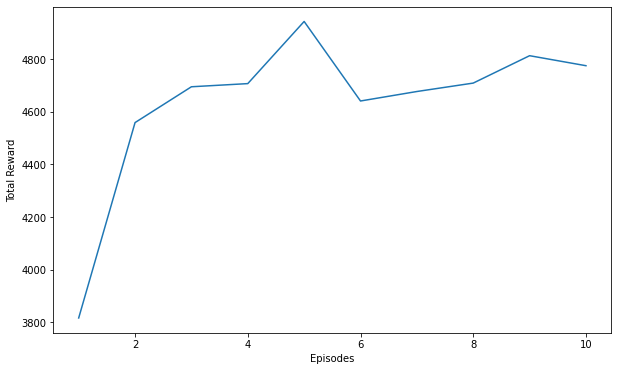

In [ ]:
# Load rewards
total_reward_list = np.loadtxt('./checkpoints/spread_robot_checkpoint' + str(episodes) + '_total_reward.txt')
# Plot
plt.figure()
plt.plot(np.arange(1, episodes+1), total_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.show()

As we can see from the previous graph, starting from the first episode the overall reward increases dramatically and oscillates gradually and shows a bouncing pattern until the final episode.

We are ready to assess the agent's performance after training our model. The ability to reproduce the trading strategy is calculated in line with the agent's action against strategy computed position.

Let's build and call a function for this purpose.

In [ ]:
def evaluate(agent, dataX, dataY, look_back):
    """
    Function run to evaluate the trained agent
    """
    
    # Length of dataset
    times = len(dataX)

    # Initial state and position
    state = dataX[:look_back, :][np.newaxis, :, :]
    pos = dataY[look_back - 1]

    # List of predicted positions
    pos_list = []
    
    done = False
    total_reward = 0
    
    for t in range(1, times - look_back + 1):

        # Predict action based on the current state
        action = agent.act(state)

        # Calculate reward
        if action == pos:   # 0:-1      1:0     2:1
            reward = +1

        else:
            reward = -1

        pos_list.append(action)
        total_reward += reward

        # Final state
        if t == times - look_back:
            done = True

        # Receive next state and position
        next_state = dataX[t:t + look_back, :][np.newaxis, :, :]
        next_pos = dataY[t + look_back - 1]

        # Remember current experience
        agent.remember(state, action, reward, next_state, done)

        # Make next_state the new current state; the same for pos
        state = next_state
        pos = next_pos

        if done:
            print('Total Reward: %i' % total_reward)

    return np.array(pos_list)

In [ ]:
from sklearn.metrics import accuracy_score

# Evaluate the model
# Make predictions
y_pred_test = evaluate(agent, X_test, y_test, look_back)

# Calculate and print accuracy
acc = accuracy_score(y_test[look_back-1:-1], y_pred_test)

print('Accuracy: %.2f %%' % (acc*100))

Total Reward: 1326
Accuracy: 93.50 %


This means that our agent provides around 93.5% of trade decisions that match with our strategy.

It is also interesting to calculate the precision and sensitivity of the model. Let's do that.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate and print precision, recall, f1 score and support
p, r, f1, s = precision_recall_fscore_support(y_test[look_back-1:-1], y_pred_test, average=None)
results = pd.DataFrame({'1-Precision': p, '2-Recall': r, '3-F1 score': f1, '4-Support': s}, index=le.classes_)

print(results.round(decimals=3))

      1-Precision  2-Recall  3-F1 score  4-Support
-1.0        0.843     0.804       0.823        194
 0.0        0.968     0.954       0.961       1282
 1.0        0.605     0.958       0.742         48


The following information is derived from the result above:
 

*   The high precision for the 0 value tells us that, in almost all cases, the model generates the hold position correctly.
*   Model is more precise and sensitive(recall) when predicting short positions. Sensitivity measures the ability of a model to predict the true positive values of each category available.
*    The support is the number of occurrences in the test subset for each class.





In [ ]:
# Decodificate labels
y_true_test = le.inverse_transform(y_test[look_back-1:-1])
y_pred_test = le.inverse_transform(y_pred_test)

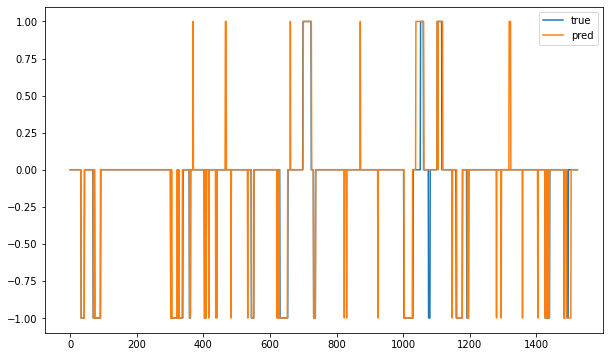

In [ ]:
# Plot strategy
plt.figure()
plt.plot(y_true_test, label='true')
plt.plot(y_pred_test, label='pred')
plt.legend()
plt.show()

The previous chart shows that prediction errors are primarily due to the short (-1) positions that the model predicts as hold (0).

## 5. Backtesting

Backtesting is the general way to see how well a strategy or model would perform. Backtesting assesses the viability of a trading strategy by finding out how it works with historical data. When backtesting works, traders and analysts can be more confident to deploy an strategy.

For the purpose of backtesting we will use the trading day immediately after.

In [14]:
# Load data into dataframe
input_file = './data/bars_6s_08jan2018.pkl'
df3 = pd.read_pickle(input_file)

Let's plot the normalized prices of our pair of stocks.

Text(0, 0.5, 'Normalized prices')

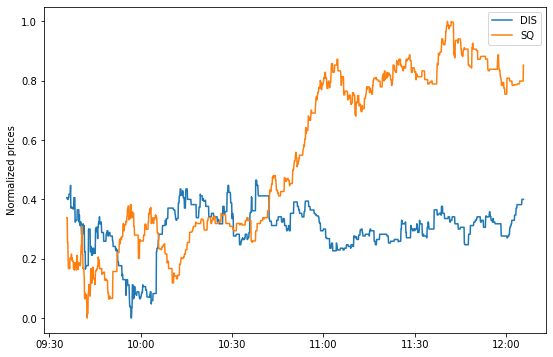

In [17]:
from matplotlib.dates import DateFormatter

data=(df3[pair]-df3[pair].min())/(df3[pair].max()-df3[pair].min())

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(data[58:1558])
ax.legend(pair,loc=0)
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
plt.ylabel('Normalized prices')

In [18]:
S1b = df3[pair[0]]
S2b = df3[pair[1]]

score, pvalue, _ = coint(S1b, S2b)
pvalue

4.753416049095904e-11

From the Cointeration test's p-value, stocks are still expected to be cointegrated.

We will perform the same computations made previously: compute the spread, its Z-Score, and prepare dataset

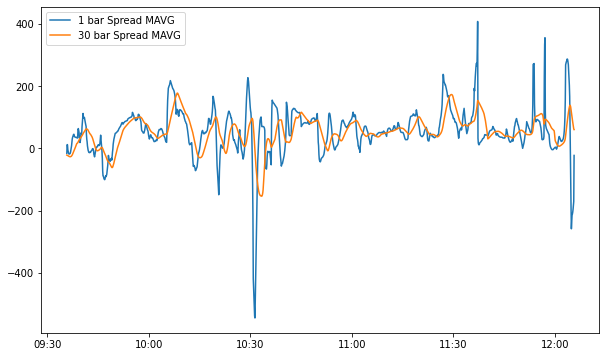

In [23]:
# Get the spread between the 2 stocks

# Calculate rolling beta coefficient
rollingb = ols.PandasRollingOLS(y=S1b, x=S2b, window=30)
spreadb = S2b - rollingb.beta['feature1'] * S1b
spreadb.name = 'spread'

# Get the 1 day moving average of the price spread
spread_mavg1b = spreadb.rolling(1).mean()
spread_mavg1b.name = 'spread 1b mavg'

# Get the 30 day moving average
spread_mavg30b = spreadb.rolling(30).mean()
spread_mavg30b.name = 'spread 30b mavg'

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(spread_mavg1b[58:1558].index, spread_mavg1b[58:1558].values)
ax.plot(spread_mavg30b[58:1558].index, spread_mavg30b[58:1558].values)
ax.legend(['1 bar Spread MAVG', '30 bar Spread MAVG'])
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))

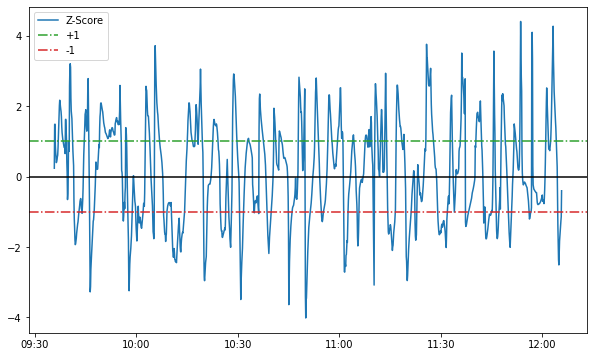

In [25]:
# Take a rolling 30 day standard deviation
std_30b = spreadb.rolling(30).std()
std_30b.name = 'std 30b'

# Compute the z score for each bar
zscore_30_1b = (spread_mavg1b - spread_mavg30b)/std_30b
zscore_30_1b.name = 'z-score'

# Plot the results
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(zscore_30_1b[58:1558].index,zscore_30_1b[58:1558].values,label='Z-Score')
ax.axhline(0, color='black')
ax.axhline(1, color='tab:green', linestyle='-.',label='+1',lw=1.5);
ax.axhline(-1, color='tab:red', linestyle='-.',label='-1',lw=1.5);
ax.legend(loc=0)
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))

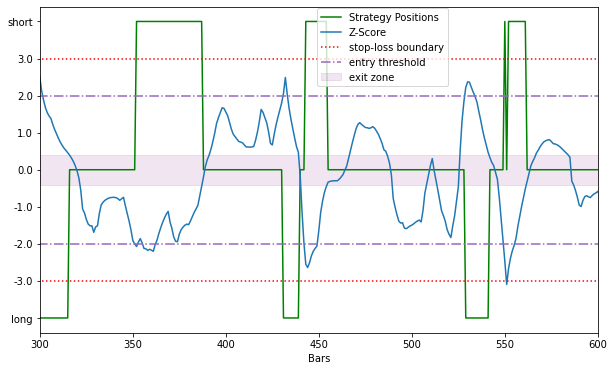

In [31]:
#Implement trading strategy
Xb, yb = prepare_dataset(zscore_30_1b)

Now let's create a ledger to keep stocks' prices, trading signals, orders, costs, and cash available.

In [ ]:
# Create ledger
tsb = df3[pair]

# Remove NAN entries
tsb = tsb[tsb.index.isin(zscore_30_1b[~np.isnan(zscore_30_1b)].index)]

# Populate columns
tsb['Zscore'] = Xb
tsb['signal'] = np.nan # initialization only
tsb['order'] = 0       # initialization only


In [ ]:
# Create trade signals

times = len(Xb) # length of dataset

signals = np.array([],dtype='int64')

# Initial state and position
state = Xb[:look_back, :][np.newaxis, :, :]

for t in range(1, times - look_back + 1):
  # Predict action based on the current state
  action = agent.act(state)
  signals = np.append(signals,action)

  # Receive next state and position
  next_state = Xb[t:t + look_back, :][np.newaxis, :, :]
                     
  # Make next_state the new current state; the same for pos
  state = next_state

# Decodificate labels
signals = le.inverse_transform(signals)

To create trading signals we will use our pre-trained agent.

In [ ]:
# Remove lookback entries
tsb = tsb[look_back:]

# Create signals column
tsb['signal'] = signals

# Populate order column
position=0

for k in range(len(tsb)):
  if tsb['signal'][k] == 1 and position==0:
    tsb.order.values[k] = 1
    position +=1
  elif tsb['signal'][k] == -1 and position==0:
    tsb.order.values[k] = -1
    position -=1
  elif tsb['signal'][k] == 0 and position < 0:
    tsb.order.values[k] = 1
    position +=1
  elif tsb['signal'][k] == 0 and position > 0:
    tsb.order.values[k] = -1
    position -=1
  elif tsb['signal'][k] == -1 and position > 0:
    tsb.order.values[k] = -2
    position -=2
  elif tsb['signal'][k] == 1 and position < 0:
    tsb.order.values[k] = 2
    position +=2

We are set to perform the backtesting, this time without considering trading costs and with 0.00 initial capital. 

Our portfolio is formed by computing the rounded mean of one stock price during the formation phase and use the result as the number of shares for the other stock. 

In [ ]:
# pd.set_option('display.max_rows', 5000)

# Backtesting (without trading costs)

# Define initial value
initial_capital = float(0.0)

N1 = pair[0]
N2 = pair[1]

# Define number of shares for each stock
qS1 = np.round(np.mean(S2))
qS2 = np.round(np.mean(S1))

# Setup cost to zero
tsb['cost_{}'.format(N1)] = float(0.0)
tsb['cost_{}'.format(N2)] = float(0.0)

# Store the amount of positions for the portfolio
tsb['dis_{}'.format(N1)] = (tsb['order'].multiply(tsb[N1]*-qS1, axis=0))
tsb['dis_{}'.format(N2)] = (tsb['order'].multiply(tsb[N2]*qS2, axis=0))

# Calculate the non-invested money (cash)
tsb['cash'] = initial_capital + (tsb['dis_{}'.format(N1)]+tsb['dis_{}'.format(N2)]).cumsum()

# Print the ledger
tsb

,DIS,SQ,Zscore,signal,order,cost_DIS,cost_SQ,dis_DIS,dis_SQ,cash
2018-01-08 09:37:18,110.185,40.2500,0.400476,1.0,1,0.0,0.0,-4297.215,4508.0,210.785
2018-01-08 09:37:24,110.185,40.2100,0.433836,1.0,0,0.0,0.0,-0.000,0.0,210.785
2018-01-08 09:37:30,110.185,40.2250,0.422939,1.0,0,0.0,0.0,-0.000,0.0,210.785
2018-01-08 09:37:36,110.180,40.2000,0.397516,1.0,0,0.0,0.0,-0.000,0.0,210.785
2018-01-08 09:37:42,110.180,40.2000,0.381835,1.0,0,0.0,0.0,-0.000,0.0,210.785
...,...,...,...,...,...,...,...,...,...,...
2018-01-08 15:59:36,110.020,40.7000,0.008879,1.0,0,0.0,0.0,-0.000,0.0,174.941
2018-01-08 15:59:42,110.020,40.6900,0.031622,1.0,0,0.0,0.0,-0.000,0.0,174.941
2018-01-08 15:59:48,110.030,40.6905,0.045329,1.0,0,0.0,0.0,-0.000,0.0,174.941
2018-01-08 15:59:54,110.025,40.7500,0.027294,1.0,0,0.0,0.0,-0.000,0.0,174.941


From the previous results, we can check that without considering trading costs, the strategy learned by the agent is p´rofitable: we started with 0.00 capital and ended up with 174.94.

Now let's consider costs. We believe that 50 bps per transaction would cover transaction costs in developed markets

In [ ]:
tsb['cash'].max()

238.08299999999144

In [ ]:
 # save the result to a pickle file
RES_DATA_FILENAME='./data/cpyML-11c_tsb.pkl'
tsb.to_pickle(RES_DATA_FILENAME) 

In [ ]:
# Backtesting (with trading costs)

# Define initial value
initial_capital = float(0.0)

N1 = pair[0]
N2 = pair[1]

# Define number of shares for each stock
qS1 = np.round(np.mean(S2))
qS2 = np.round(np.mean(S1))

# Store the amount of positions for the portfolio
tsb['dis_{}'.format(N1)] = (tsb['order'].multiply(tsb[N1]*-qS1, axis=0))
tsb['dis_{}'.format(N2)] = (tsb['order'].multiply(tsb[N2]*qS2, axis=0))

# Compute cost
cost = 50*0.0001 # 50bps per transaction
tsb['cost_{}'.format(N1)] = float(0.0)
tsb['cost_{}'.format(N2)] = float(0.0)

for i in range(len(tsb)):
  if tsb['order'][i] > 0:
    tsb['cost_{}'.format(N1)][i] = tsb['order'][i]*tsb[N1][i]*-qS1*(cost)
    tsb['cost_{}'.format(N2)][i] = tsb['order'][i]*tsb[N2][i]*qS2*(-cost) 
  elif tsb['order'][i] < 0:
    tsb['cost_{}'.format(N1)][i] = tsb['order'][i]*tsb[N1][i]*-qS1*(-cost)
    tsb['cost_{}'.format(N2)][i] = tsb['order'][i]*tsb[N2][i]*qS2*(cost)

# Calculate the non-invested money (cash)
tsb['cash'] = initial_capital + (tsb['dis_{}'.format(N1)]+tsb['dis_{}'.format(N2)]+tsb['cost_{}'.format(N1)]+tsb['cost_{}'.format(N2)]).cumsum()


# Print the ledger
tsb

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to b

,DIS,SQ,Zscore,signal,order,cost_DIS,cost_SQ,dis_DIS,dis_SQ,cash
2018-01-08 09:37:18,110.185,40.2500,0.400476,1.0,1,-21.486075,-22.54,-4297.215,4508.0,166.758925
2018-01-08 09:37:24,110.185,40.2100,0.433836,1.0,0,0.000000,0.00,-0.000,0.0,166.758925
2018-01-08 09:37:30,110.185,40.2250,0.422939,1.0,0,0.000000,0.00,-0.000,0.0,166.758925
2018-01-08 09:37:36,110.180,40.2000,0.397516,1.0,0,0.000000,0.00,-0.000,0.0,166.758925
2018-01-08 09:37:42,110.180,40.2000,0.381835,1.0,0,0.000000,0.00,-0.000,0.0,166.758925
...,...,...,...,...,...,...,...,...,...,...
2018-01-08 15:59:36,110.020,40.7000,0.008879,1.0,0,0.000000,0.00,-0.000,0.0,-24432.890910
2018-01-08 15:59:42,110.020,40.6900,0.031622,1.0,0,0.000000,0.00,-0.000,0.0,-24432.890910
2018-01-08 15:59:48,110.030,40.6905,0.045329,1.0,0,0.000000,0.00,-0.000,0.0,-24432.890910
2018-01-08 15:59:54,110.025,40.7500,0.027294,1.0,0,0.000000,0.00,-0.000,0.0,-24432.890910


In [ ]:
tsb['cash'].max()

201.97978499999985

From the previous results, it is clear that the strategy is far from profitable when considering trading costs. However, we can also check that if an exit trigger exists, the strategy could be profitable by ending up sooner.

## 6. Conclusion

In this analysis, we deployed two Machine Learning algorithms to approach a very known trade strategy, Pairs Trading. First, we use an RNN to predict 15 timesteps ahead of the pair's spread. Then we trained an RL agent to learn our trading strategy which was based on the Z-Score behavior of the spread.

In the end, we realized that the agent learned quite well our trading strategy, but the same strategy is not profitable without a return-driven signal when accounting trading costs.